# Versão 3.0 – IA com rede neural otimizada e estratégia simulada

### 🧭 Índice do Projeto – Rede Neural com Estratégia Simulada

0. [📦 Imports e Configurações Iniciais](#0-imports-e-configurações-iniciais)
1. [📥 Coleta de Dados e Indicadores Técnicos](#1-coleta-de-dados-e-indicadores-técnicos)  
2. [⚙️ Engenharia de Features (Lags + Indicadores)](#2-engenharia-de-features-lags--indicadores)  
3. [🔄 Normalização + Separação Treino/Teste](#3-normalização--separação-treino/teste)  
4. [🧠 Modelagem com Keras + Keras Tuner](#4-modelagem-com-keras--keras-tuner)  
5. [💾 Salvamento Automático dos Modelos](#5-salvamento-automático-dos-modelos)  
6. [📊 Avaliação do Modelo + Confiança](#6-avaliação-do-modelo--confiança)  
7. [🎯 Filtro de Convicção](#7-filtro-de-convicção)  
8. [💸 Simulação da Estratégia](#8-simulação-da-estratégia)  
9. [📋 Análise de Performance](#9-análise-de-performance)  
10. [🔍 Interpretação com SHAP](#10-interpretação-com-shap)  
11. [🧠 Carregamento do Melhor Modelo](#11-carregamento-do-melhor-modelo)  
12. [🏆 Comparação dos Top 3 Modelos](#12-comparação-dos-top-3-modelos)

## 0. Imports e Configurações Iniciais

In [3]:
# 📁 Bibliotecas de sistema
import os
import random
from datetime import datetime
import re

# 📊 Manipulação de dados
import numpy as np
import pandas as pd
import yfinance as yf

# 🛠️ Pré-processamento e métricas
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# 📈 Indicadores técnicos
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.volume import OnBalanceVolumeIndicator

# 🤖 Rede neural
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision

# 🔍 Otimização de hiperparâmetros
import keras_tuner as kt

# 🧠 Interpretação de modelos
import shap

# 📉 Visualização
import matplotlib.pyplot as plt
import seaborn as sns

/Users/gabrielpereiralimacesardeoliveira/.pyenv/versions/tf-keras/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 📌 Ativa precisão mista (float16) para acelerar treino com Apple Silicon
mixed_precision.set_global_policy('mixed_float16')
print("🚀 mixed_precision ativado: float16 para acelerar treinos!")

🚀 mixed_precision ativado: float16 para acelerar treinos!


In [5]:
# 🎯 Define semente para resultados reprodutíveis (aléa. controlada em numpy, random e tensorflow)
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print(f"Semente global definida para {SEED}")

Semente global definida para 42


## 1. Coleta de Dados e Indicadores Técnicos

In [6]:
# 🗓️ Coleta do histórico do ativo com ajuste de dividendos
ticker = 'PETR4.SA'
dados = yf.download(ticker, start='2007-01-01', end='2025-03-31', auto_adjust=True)

# 🔧 Ajuste para evitar MultiIndex nas colunas
if isinstance(dados.columns, pd.MultiIndex):
    dados.columns = dados.columns.get_level_values(0)

# 🎯 Seleciona preço de fechamento e volume
dados = dados[['Close', 'Volume']].rename(columns={'Close': 'preco'})

# 🏁 Define o alvo: se o preço em 3 dias subir, alvo = 1 (alta); caso contrário, 0 (queda)
dados['retorno_3d'] = dados['preco'].shift(-3) / dados['preco'] - 1
dados['alvo'] = (dados['retorno_3d'] > 0).astype(int)

[*********************100%***********************]  1 of 1 completed


## 2. Engenharia de Features (Lags + Indicadores)

In [7]:
# 🔁 Lags de preço (últimos 10 dias)
for i in range(1, 11):
    dados[f'lag_{i}'] = dados['preco'].shift(i)

# ⚙️ RSI (Índice de Força Relativa)
dados['rsi'] = RSIIndicator(close=dados['preco'], window=14).rsi()

# ⚙️ MACD (convergência/divergência de médias móveis)
macd = MACD(close=dados['preco'])
dados['macd_line'] = macd.macd()
dados['macd_hist'] = macd.macd_diff()

# ⚙️ OBV (On Balance Volume)
dados['obv'] = OnBalanceVolumeIndicator(close=dados['preco'], volume=dados['Volume']).on_balance_volume()

# ⚙️ Bandas de Bollinger (distância do preço até as bandas)
bb = BollingerBands(close=dados['preco'])
dados['bb_up_dist'] = bb.bollinger_hband() - dados['preco']
dados['bb_down_dist'] = dados['preco'] - bb.bollinger_lband()

# 🧼 Remove linhas com valores faltantes gerados pelos indicadores
dados.dropna(inplace=True)

In [8]:
# 🔍 Verifica se há NaNs e mostra um resumo
print("🔎 Verificação dos dados:")
display(dados.isna().sum())
display(dados.describe().T)

🔎 Verificação dos dados:


Price
preco           0
Volume          0
retorno_3d      0
alvo            0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
rsi             0
macd_line       0
macd_hist       0
obv             0
bb_up_dist      0
bb_down_dist    0
dtype: int64

,count,mean,std,min,25%,50%,75%,max
Price,,,,,,,,
preco,4490.0,1.116159e+01,7.872963e+00,1.552495e+00,6.617472e+00,8.783090e+00,1.195244e+01,3.814473e+01
Volume,4490.0,4.492472e+07,3.389086e+07,0.000000e+00,2.262500e+07,3.652125e+07,5.797272e+07,6.989506e+08
retorno_3d,4490.0,2.271753e-03,4.802077e-02,-4.031237e-01,-2.216465e-02,1.923073e-03,2.727191e-02,3.596985e-01
alvo,4490.0,5.187082e-01,4.997055e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
lag_1,4490.0,1.115507e+01,7.864346e+00,1.552495e+00,6.617472e+00,8.779518e+00,1.195068e+01,3.814473e+01
lag_2,4490.0,1.114862e+01,7.855914e+00,1.552495e+00,6.617472e+00,8.777956e+00,1.194538e+01,3.814473e+01
lag_3,4490.0,1.114218e+01,7.847418e+00,1.552495e+00,6.617472e+00,8.776049e+00,1.194142e+01,3.814473e+01
lag_4,4490.0,1.113586e+01,7.839290e+00,1.552495e+00,6.617472e+00,8.775189e+00,1.194055e+01,3.814473e+01
lag_5,4490.0,1.112953e+01,7.831218e+00,1.552495e+00,6.617472e+00,8.773528e+00,1.193715e+01,3.814473e+01


## 3. Normalização + Separação Treino/Teste

In [9]:
# 🏗️ Seleção automática das colunas que serão usadas como features (inputs do modelo)
# Inclui todos os lags e indicadores específicos definidos manualmente
features = [col for col in dados.columns if 'lag_' in col or col in [
    'rsi', 'macd_line', 'macd_hist', 'obv', 'bb_up_dist', 'bb_down_dist'
]]

# ⚖️ Normalização Min-Max: coloca todos os dados entre 0 e 1 para facilitar o aprendizado da rede
scaler = MinMaxScaler()
dados[features] = scaler.fit_transform(dados[features])

# 🎯 Separação em X (features) e y (alvo)
X = dados[features].values
y = dados['alvo'].values

# 🔀 Divisão treino/teste respeitando a ordem temporal dos dados (sem embaralhar!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [10]:
# 1. Verificar o shape dos datasets:
print(f"✅ X_train: {X_train.shape} | X_test: {X_test.shape}")
print(f"🎯 y_train: {y_train.shape} | y_test: {y_test.shape}")

✅ X_train: (3592, 16) | X_test: (898, 16)
🎯 y_train: (3592,) | y_test: (898,)


In [11]:
# 2. Visualização de consistência:
# Formata os números com 4 casas decimais para facilitar a leitura
pd.options.display.float_format = '{:,.4f}'.format

# Plota distribuição dos dados depois da normalização (esperado entre 0 e 1)
pd.DataFrame(X_train, columns=features).describe().T[['min', 'max']]

,min,max
lag_1,0.0000,0.4214
lag_2,0.0000,0.4214
lag_3,0.0000,0.4214
lag_4,0.0000,0.4214
lag_5,0.0000,0.4214
lag_6,0.0000,0.4214
lag_7,0.0000,0.4214
lag_8,0.0000,0.4214
lag_9,0.0000,0.4214
lag_10,0.0000,0.4214


## 4. Modelagem com Keras + Keras Tuner

### 4. 🧠 Construção da Rede Neural com Keras + Tuner

Neste bloco, usamos o `Keras Tuner` para encontrar a arquitetura ideal de rede neural que **melhore a acurácia da previsão de alta ou queda do ativo**.

📌 O modelo é composto por:
- Camada de entrada com número ajustável de neurônios
- De 1 a 3 camadas ocultas com Dropout
- Saída binária (alta ou queda)
- Otimizador Adam com taxa de aprendizado tunável

In [12]:
# 4. 🔧 Construção da rede neural com Keras + Tuner

# 🧠 Função que constrói e retorna um modelo de rede neural ajustável
def build_model(hp):
    model = Sequential()

    # 📥 Camada de entrada
    model.add(Dense(
        hp.Int('units_input', 32, 128, step=16),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))

    # 🏗️ Camadas ocultas
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(Dense(hp.Int(f'units_{i}', 16, 128, step=16), activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

    # 📤 Saída com dtype forçado por causa do float16
    model.add(Dense(1, activation='sigmoid', dtype='float32'))

    # ⚙️ Compilação do modelo
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-3, 5e-4, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# 🔍 Tuner para encontrar os melhores hiperparâmetros
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=200,
    directory='ia_tuning',
    project_name='petr4',
    overwrite=True
)

# ⏳ Callback para parar o treino cedo caso não melhore
early_stop = EarlyStopping(patience=15, restore_best_weights=True)

# 🚀 Ajuste dos hiperparâmetros
tuner.search(
    X_train, y_train,
    epochs=600,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)

# 🎯 Melhor modelo encontrado
best_model = tuner.get_best_models(num_models=1)[0]

# 🧪 Refit final
best_model.fit(
    X_train, y_train,
    epochs=600,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=2
)

Trial 200 Complete [00h 00m 03s]
val_accuracy: 0.4621380865573883

Best val_accuracy So Far: 0.5913140177726746
Total elapsed time: 00h 10m 38s
Epoch 1/600


/Users/gabrielpereiralimacesardeoliveira/.pyenv/versions/tf-keras/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


57/57 - 1s - 15ms/step - accuracy: 0.5209 - loss: 0.6921 - val_accuracy: 0.5646 - val_loss: 0.6868
Epoch 2/600
57/57 - 0s - 2ms/step - accuracy: 0.5128 - loss: 0.6922 - val_accuracy: 0.5947 - val_loss: 0.6870
Epoch 3/600
57/57 - 0s - 2ms/step - accuracy: 0.5106 - loss: 0.6925 - val_accuracy: 0.5924 - val_loss: 0.6878
Epoch 4/600
57/57 - 0s - 2ms/step - accuracy: 0.5200 - loss: 0.6910 - val_accuracy: 0.5501 - val_loss: 0.6886
Epoch 5/600
57/57 - 0s - 3ms/step - accuracy: 0.5164 - loss: 0.6921 - val_accuracy: 0.5423 - val_loss: 0.6890
Epoch 6/600
57/57 - 0s - 2ms/step - accuracy: 0.5309 - loss: 0.6913 - val_accuracy: 0.5379 - val_loss: 0.6891
Epoch 7/600
57/57 - 0s - 2ms/step - accuracy: 0.5226 - loss: 0.6915 - val_accuracy: 0.5412 - val_loss: 0.6901
Epoch 8/600
57/57 - 0s - 2ms/step - accuracy: 0.5281 - loss: 0.6907 - val_accuracy: 0.5390 - val_loss: 0.6899
Epoch 9/600
57/57 - 0s - 2ms/step - accuracy: 0.5200 - loss: 0.6915 - val_accuracy: 0.5390 - val_loss: 0.6896
Epoch 10/600
57/57 - 

## 5. Salvamento Automático dos Modelos

### 💾 Salvamento Automático dos Modelos + hiperparâmetros

Neste bloco, após encontrar o melhor modelo com o Keras Tuner, salvamos automaticamente:

- 🧠 O **modelo em formato `.h5`**
- 📄 Um **arquivo `.txt` com os hiperparâmetros otimizados**
- O nome do arquivo inclui o **score de validação** e o **timestamp** do salvamento.

Essa etapa permite que a IA treinada seja reaproveitada depois, sem necessidade de retreinar.

In [13]:
# 4.2 💾 Salvando automaticamente o melhor modelo + hiperparâmetros

# ✅ Recupera o melhor modelo encontrado pelo tuner
best_model = tuner.get_best_models(num_models=1)[0]

# ✅ Resgata a melhor trial (score e hiperparâmetros)
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_score = best_trial.score
best_params = best_trial.hyperparameters.values

# ✅ Cria a pasta de modelos se não existir
os.makedirs("ia_tuning/modelos", exist_ok=True)

# 📌 Gera nome do arquivo com timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
base_name = f"ia_tuning/modelos/modelo_{best_score:.4f}_{timestamp}"

# 💾 Salva o modelo (.h5)
best_model.save(f"{base_name}.h5")

# 📜 Salva os hiperparâmetros utilizados (.txt)
with open(f"{base_name}_params.txt", "w") as f:
    f.write(f"Score: {best_score:.4f}\n")
    f.write("Hiperparâmetros:\n")
    for key, value in best_params.items():
        f.write(f"- {key}: {value}\n")

# ✅ Mensagens amigáveis
print("✅ Modelo e parâmetros salvos com sucesso!")
print("🧠 Caminho do modelo salvo:", base_name + ".h5")

✅ Modelo e parâmetros salvos com sucesso!
🧠 Caminho do modelo salvo: ia_tuning/modelos/modelo_0.5913_2025-04-21_04-22.h5


## 6. Avaliação do Modelo + Confiança

### 📊 Avaliação do Modelo + Confiança

Nesta seção, avaliamos o desempenho do modelo treinado com base em métricas tradicionais de classificação binária.

📌 Etapas executadas:
- **Predição das probabilidades e classes** no conjunto de teste.
- **Relatório completo (`classification_report`)** com precisão, recall e f1-score para cada classe (Queda/Alta).
- **Resumo explicativo** destacando as métricas principais:
  - *Acurácia* → Total de acertos do modelo
  - *Precisão* → Qualidade das previsões de "alta"
  - *Recall* → Capacidade de encontrar as "altas" reais
  - *F1-Score* → Equilíbrio entre precisão e recall
- **Matriz de confusão explicada** visualmente com os acertos e erros categorizados.

Além disso, o DataFrame `df_pred` foi atualizado com:
- Probabilidade da previsão
- Classe prevista (0 ou 1)
- **Convicção** da previsão (confiança do modelo)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
📊 Relatório detalhado das métricas de classificação:
              precision    recall  f1-score   support

       Queda       0.65      0.15      0.25       395
        Alta       0.58      0.93      0.72       503

    accuracy                           0.59       898
   macro avg       0.62      0.54      0.48       898
weighted avg       0.61      0.59      0.51       898


🧠 Avaliação do Modelo:
• Acurácia         → 59.13%     (Percentual total de acertos)
• Precisão (Alta)  → 58.46%     (Entre as vezes que previu alta, quantas estavam corretas)
• Recall (Alta)    → 93.44%     (Entre todas as altas reais, quantas foram identificadas)
• F1-Score         → 71.92%     (Equilíbrio entre precisão e recall)



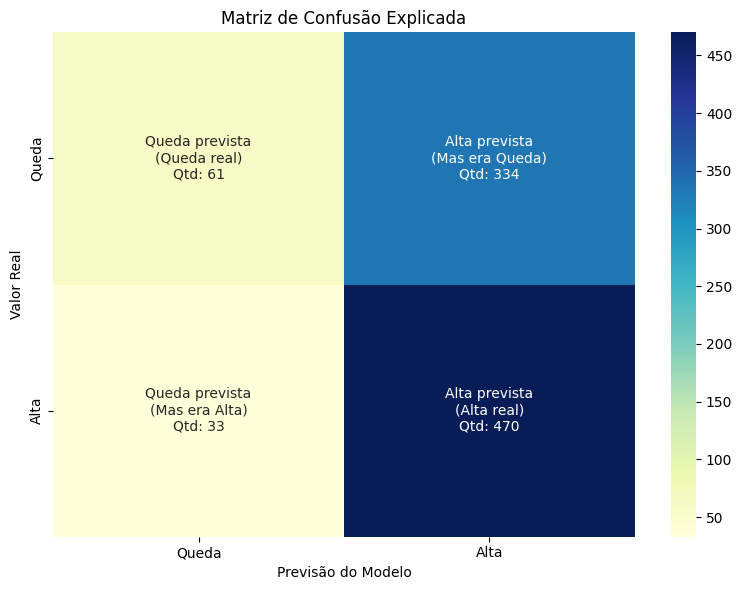

🔎 Top 10 previsões com maior convicção do modelo:


Price,preco,Volume,retorno_3d,alvo,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_10,rsi,macd_line,macd_hist,obv,bb_up_dist,bb_down_dist,Previsao,Probabilidade,Conviccao
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-27,12.4320,76465300,-0.0509,0,0.2854,0.2883,0.2865,0.2798,0.2748,0.2753,...,0.2879,0.7339,0.5990,0.6671,0.6624,0.0908,0.3758,1,0.5314,0.0627
2021-08-25,12.1004,46031200,0.0206,1,0.2865,0.2798,0.2748,0.2753,0.2770,0.2799,...,0.2802,0.6709,0.5858,0.6469,0.6590,0.1095,0.3441,1,0.5311,0.0622
2021-08-30,12.3491,61054000,-0.0601,0,0.2973,0.2854,0.2883,0.2865,0.2798,0.2748,...,0.2799,0.7001,0.6053,0.6720,0.6564,0.1011,0.3524,1,0.5310,0.0621
2021-08-26,11.9957,41061300,-0.0109,0,0.2883,0.2865,0.2798,0.2748,0.2753,0.2770,...,0.2851,0.6272,0.5875,0.6436,0.6549,0.1236,0.3308,1,0.5303,0.0607
2021-08-24,12.0350,49831400,0.0330,1,0.2798,0.2748,0.2753,0.2770,0.2799,0.2799,...,0.2759,0.6539,0.5797,0.6363,0.6544,0.1095,0.3371,1,0.5301,0.0603
2021-09-27,11.8430,89178700,0.0033,1,0.2784,0.2776,0.2658,0.2582,0.2515,0.2549,...,0.2704,0.5993,0.5326,0.6717,0.6437,0.1211,0.3410,1,0.5299,0.0598
2021-09-29,11.9520,58731700,0.0511,1,0.2791,0.2812,0.2784,0.2776,0.2658,0.2582,...,0.2716,0.6193,0.5521,0.6961,0.6379,0.0995,0.3460,1,0.5298,0.0595
2023-03-08,16.2525,66220400,-0.0484,0,0.3961,0.4112,0.4066,0.3881,0.3996,0.3986,...,0.4077,0.4754,0.5280,0.5219,0.8069,0.1972,0.2557,1,0.5297,0.0594
2023-02-14,17.0709,35839000,-0.0097,0,0.4258,0.4244,0.4106,0.4127,0.4052,0.4080,...,0.4131,0.6320,0.6220,0.6555,0.7968,0.1239,0.3518,1,0.5296,0.0592


In [14]:
# 4️⃣ Avaliação do Modelo – Métricas + Matriz + Confiança

# 📌 1. Previsões do modelo e probabilidade da classe 1 (Alta)
y_prob = best_model.predict(X_test).flatten()
y_pred = (y_prob > 0.5).astype(int)

# 📊 2. Relatório técnico das métricas de classificação
print("📊 Relatório detalhado das métricas de classificação:")
print(classification_report(y_test, y_pred, target_names=["Queda", "Alta"]))

# ✅ 3. Resumo interpretativo com explicações
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"""
🧠 Avaliação do Modelo:
• Acurácia         → {acc:.2%}     (Percentual total de acertos)
• Precisão (Alta)  → {prec:.2%}     (Entre as vezes que previu alta, quantas estavam corretas)
• Recall (Alta)    → {rec:.2%}     (Entre todas as altas reais, quantas foram identificadas)
• F1-Score         → {f1:.2%}     (Equilíbrio entre precisão e recall)
""")

# 📉 4. Matriz de confusão com rótulos explicativos
cm = confusion_matrix(y_test, y_pred)
labels_texto = np.array([
    [f"Queda prevista\n(Queda real)\nQtd: {cm[0,0]}",
     f"Alta prevista\n(Mas era Queda)\nQtd: {cm[0,1]}"],
    [f"Queda prevista\n(Mas era Alta)\nQtd: {cm[1,0]}",
     f"Alta prevista\n(Alta real)\nQtd: {cm[1,1]}"]
])

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=labels_texto, fmt='', cmap='YlGnBu', 
            xticklabels=['Queda', 'Alta'], yticklabels=['Queda', 'Alta'])
plt.title("Matriz de Confusão Explicada")
plt.xlabel("Previsão do Modelo")
plt.ylabel("Valor Real")
plt.tight_layout()
plt.show()

# 🔍 5. Análise de convicção (quão confiante o modelo está em cada previsão)
df_pred = dados.iloc[-len(y_test):].copy()  # Evita SettingWithCopyWarning
df_pred['Previsao'] = y_pred
df_pred['Probabilidade'] = y_prob
df_pred['Conviccao'] = abs(y_prob - 0.5) * 2  # De 0 (incerteza) a 1 (confiança máxima)

# 👑 6. Visualização das previsões mais confiantes
print("🔎 Top 10 previsões com maior convicção do modelo:")
display(df_pred.sort_values('Conviccao', ascending=False).head(10))

## 7. Filtro de Convicção

### 🎯 Avaliação com Filtro de Convicção

Essa seção foca em analisar apenas as previsões em que a rede neural demonstrou maior confiança, filtrando com base na métrica de **convicção** (distância da probabilidade para 0.5). Isso nos permite validar se, mesmo errando no geral, o modelo acerta mais quando está seguro.

In [15]:
# 7. 🎯 Avaliação com Filtro de Convicção

# 📊 Estatísticas gerais da coluna 'Conviccao'
print("📊 Estatísticas da coluna Conviccao:")
print(df_pred['Conviccao'].describe())

print("\n🔢 Valores únicos e frequência:")
print(df_pred['Conviccao'].value_counts().sort_index())

# 🔍 Define o limiar mínimo de convicção para considerar a previsão
limiar_conviccao = 0.2  # Pode testar 0.1, 0.15, etc.

# 🧠 Filtra apenas previsões com convicção ≥ limiar
df_convicto = df_pred[df_pred['Conviccao'] >= limiar_conviccao].copy()

# ⚠️ Caso não haja nenhuma previsão com convicção suficiente
if df_convicto.empty:
    print(f"⚠️ Nenhuma previsão com convicção ≥ {limiar_conviccao}. Tente reduzir o limiar.")
else:
    # 📈 Acurácia apenas nas previsões mais confiantes
    acc_conf = accuracy_score(df_convicto['alvo'], df_convicto['Previsao'])
    qtd = len(df_convicto)
    total = len(df_pred)

    print(f"✅ Acurácia com convicção ≥ {limiar_conviccao}: {acc_conf:.2%}")
    print(f"📦 Previsões com convicção alta: {qtd} de {total} ({qtd / total:.2%})")

    # 📊 Matriz de Confusão explicada para essas previsões
    cm_conf = confusion_matrix(df_convicto['alvo'], df_convicto['Previsao'])

    labels_expl = [
        [f"✅ Queda prevista\n(Queda real)\nQtd: {cm_conf[0,0]}",  f"❌ Alta prevista\n(Mas era Queda)\nQtd: {cm_conf[0,1]}"],
        [f"❌ Queda prevista\n(Mas era Alta)\nQtd: {cm_conf[1,0]}", f"✅ Alta prevista\n(Alta real)\nQtd: {cm_conf[1,1]}"]
    ]

    plt.figure(figsize=(8,6))
    sns.heatmap(
        cm_conf,
        annot=labels_expl,
        fmt='',
        cmap='YlGnBu',
        xticklabels=['Queda', 'Alta'],
        yticklabels=['Queda', 'Alta']
    )
    plt.title(f"📊 Matriz de Confusão Explicada\n(Convicção ≥ {limiar_conviccao})")
    plt.xlabel("🔮 Previsão do Modelo")
    plt.ylabel("📌 Valor Real")
    plt.tight_layout()
    plt.show()

📊 Estatísticas da coluna Conviccao:
count   898.0000
mean      0.0286
std       0.0176
min       0.0000
25%       0.0131
50%       0.0293
75%       0.0445
max       0.0627
Name: Conviccao, dtype: float64

🔢 Valores únicos e frequência:
Conviccao
0.0000    1
0.0001    1
0.0002    1
0.0002    1
0.0003    1
         ..
0.0603    1
0.0607    1
0.0621    1
0.0622    1
0.0627    1
Name: count, Length: 898, dtype: int64
⚠️ Nenhuma previsão com convicção ≥ 0.2. Tente reduzir o limiar.


## 8. Simulação da Estratégia

### 🧬 Simulação da Estratégia

Neste bloco, simulamos o comportamento da estratégia da rede neural ao aplicar **R$100 iniciais** no mercado.

📌 Lógica da simulação:
- A cada dia, o modelo verifica se a **probabilidade da classe 1 (alta)** é maior que `0.5`.
- Se for, a IA entra **comprada**.
- A operação dura **3 dias**.
- Ao final, o capital é multiplicado pelo retorno da operação.
- O resultado de cada operação é salvo na **lista de trades** e usado para construir a **curva de capital**.

Essa simulação nos permite avaliar como o modelo performaria se fosse usado como um robô de trading com regras simples.

In [16]:
# 💰 Simulação da Estratégia com R$100 Iniciais
capital = 100  # Capital inicial
capital_curve = [capital]  # Curva de capital ao longo do tempo
trades = []  # Lista para armazenar os trades realizados

# 🧠 Lógica: operar comprado quando a IA tem probabilidade > 0.5
for i in range(len(df_pred) - 3):  # -3 por causa do horizonte de 3 dias
    prob = df_pred['Probabilidade'].iloc[i]
    
    if prob > 0.5:  # Sinal de entrada
        preco_entrada = df_pred['preco'].iloc[i]
        preco_saida = df_pred['preco'].iloc[i + 3]
        retorno = preco_saida / preco_entrada
        lucro = capital * (retorno - 1)
        
        # Salva detalhes da operação
        trades.append({
            'Data Entrada': df_pred.index[i],
            'Data Saída': df_pred.index[i + 3],
            'Retorno (%)': (retorno - 1) * 100,
            'Lucro (R$)': lucro
        })
        
        capital *= retorno  # Atualiza capital

    capital_curve.append(capital)  # Registra o capital a cada passo

# Adiciona a curva de capital ao DataFrame principal
df_pred = df_pred.iloc[:len(capital_curve)]
df_pred['Capital'] = capital_curve

### 8.1 📈 Curva de Capital vs. Buy & Hold

Este gráfico compara a evolução do capital da estratégia da IA com uma estratégia passiva de **Buy & Hold**.

🟢 IA (Capital): usa o modelo para entrar ou não nas operações com base na convicção da previsão.

⚪ Buy & Hold: simula uma compra única no início e mantida até o fim, sem negociação.

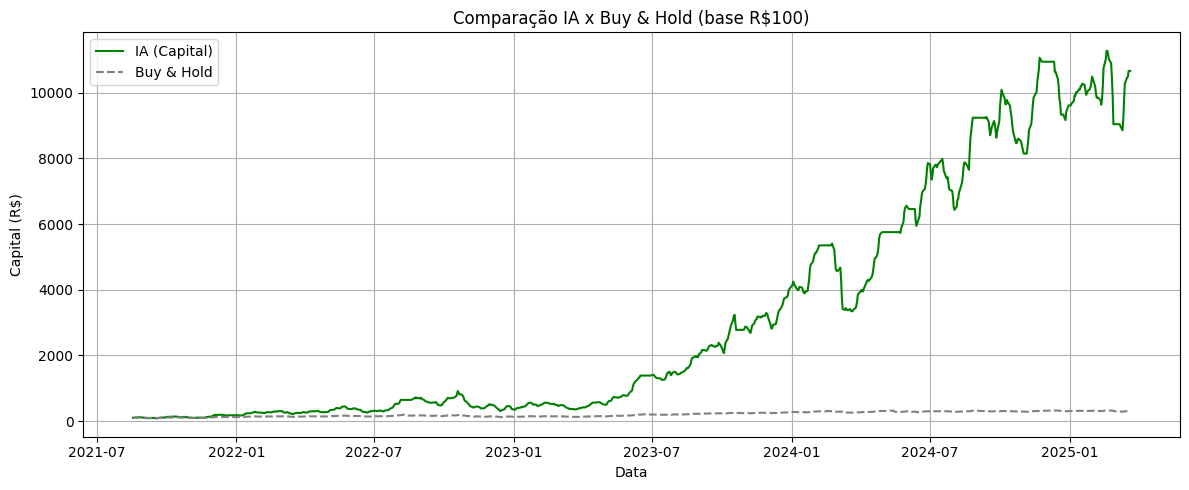

In [17]:
# 📊 Comparação entre a estratégia da IA e Buy & Hold (base R$100)
plt.figure(figsize=(12, 5))

# Curva de capital da IA
plt.plot(df_pred.index, df_pred['Capital'], label='IA (Capital)', color='green')

# Buy & Hold: preço atual dividido pelo inicial * R$100
plt.plot(
    df_pred.index,
    df_pred['preco'] / df_pred['preco'].iloc[0] * 100,
    label='Buy & Hold',
    color='gray',
    linestyle='--'
)

plt.title('Comparação IA x Buy & Hold (base R$100)')
plt.ylabel('Capital (R$)')
plt.xlabel('Data')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 9. Análise de Performance

### Tabela de Trades e Análise de Performance

### 9.1 📋 Tabela de Trades Realizados e Exportação

Nesta seção, visualizamos todas as operações realizadas pela IA durante o período de teste.

Cada linha representa uma simulação de trade com:

- 📅 **Data** de entrada e saída  
- 📈 **Retorno percentual** da operação  
- 💰 **Lucro financeiro** em R$

Além disso, a tabela é exportada como um arquivo `.csv` para análises posteriores.

In [18]:
# 📋 Cria DataFrame com os trades realizados
trades_df = pd.DataFrame(trades)

# 🖨️ Mostra os primeiros registros para inspeção
print(trades_df.head())

# 💾 Exporta para CSV (pode ser lido no Excel, Python, etc.)
trades_df.to_csv("trades_simulados_ia.csv", index=False)

  Data Entrada Data Saída  Retorno (%)  Lucro (R$)
0   2021-08-18 2021-08-23       0.8585      0.8585
1   2021-08-19 2021-08-24       3.5285      3.5588
2   2021-08-20 2021-08-25       4.2481      4.4358
3   2021-08-23 2021-08-26       1.7395      1.8934
4   2021-08-24 2021-08-27       3.2995      3.6541


### 9.2 📈 Análise de Performance da Estratégia

Aqui avaliamos a performance da estratégia da IA com base nas operações realizadas:

- 🟢 Evolução do capital (curva de capital)
- 📉 Cálculo do máximo drawdown (maior queda acumulada)
- 📅 Período total e número de anos
- 💹 Rentabilidade total e anualizada
- ✅ Taxa de acerto e número de operações

Essas métricas ajudam a entender se a estratégia é consistente e viável para uso real.

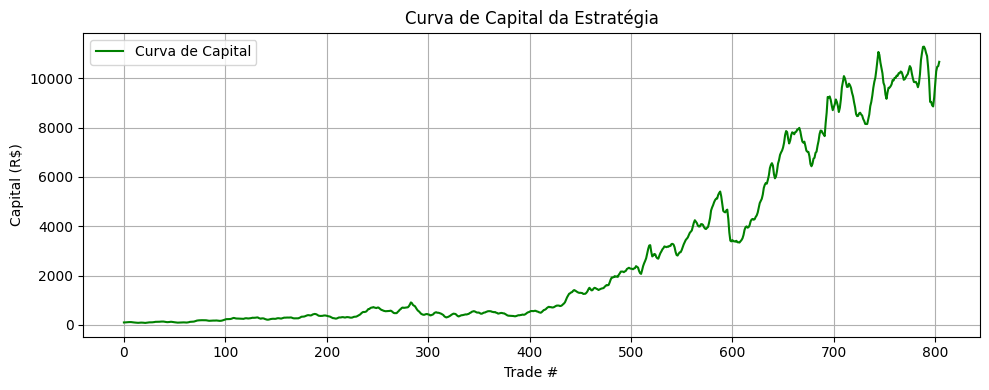

📅 Período: 2021-08-18 até 2025-03-21 (3.59 anos)
💼 Capital inicial: R$100.00
💰 Capital final: R$10662.97
📈 Rentabilidade total: 10562.97%
📅 Rentabilidade anualizada: 267.26%
🔁 Total de trades: 804
✅ Taxa de acerto: 58.46%
📉 Máximo Drawdown: -66.77%


In [19]:
# 🗂️ Carrega a tabela com os trades simulados (já exportada anteriormente)
trades_df = pd.read_csv("trades_simulados_ia.csv", parse_dates=["Data Entrada", "Data Saída"])

# 🟢 1. Curva de Capital (simula reinvestimento contínuo)
capital_inicial = 100
capital = capital_inicial
capital_curve = [capital]

for lucro in trades_df["Lucro (R$)"]:
    capital += lucro
    capital_curve.append(capital)

serie_capital = pd.Series(capital_curve)

# 📉 2. Cálculo de Drawdown (picos e quedas)
pico = serie_capital.cummax()
drawdown = (serie_capital - pico) / pico
max_drawdown = drawdown.min()

# 📆 3. Período da simulação
inicio = trades_df["Data Entrada"].min()
fim = trades_df["Data Saída"].max()
dias = (fim - inicio).days
anos = dias / 365.25

# 💹 4. Rentabilidades
capital_final = capital_curve[-1]
rentabilidade_total = (capital_final / capital_inicial - 1) * 100
rent_anualizada = (capital_final / capital_inicial) ** (1 / anos) - 1

# ✅ 5. Taxa de acerto e número de operações
total_trades = len(trades_df)
acertos = (trades_df["Lucro (R$)"] > 0).sum()
taxa_acerto = acertos / total_trades

# 📊 6. Plot da curva de capital
plt.figure(figsize=(10, 4))
plt.plot(serie_capital, label='Curva de Capital', color='green')
plt.title("Curva de Capital da Estratégia")
plt.xlabel("Trade #")
plt.ylabel("Capital (R$)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 📋 7. Relatório Final
print(f"📅 Período: {inicio.date()} até {fim.date()} ({anos:.2f} anos)")
print(f"💼 Capital inicial: R${capital_inicial:.2f}")
print(f"💰 Capital final: R${capital_final:.2f}")
print(f"📈 Rentabilidade total: {rentabilidade_total:.2f}%")
print(f"📅 Rentabilidade anualizada: {rent_anualizada:.2%}")
print(f"🔁 Total de trades: {total_trades}")
print(f"✅ Taxa de acerto: {taxa_acerto:.2%}")
print(f"📉 Máximo Drawdown: {max_drawdown:.2%}")

## 10. Interpretação com SHAP

### 📌 Interpretação com SHAP (Explicabilidade da Rede Neural)

O SHAP (SHapley Additive exPlanations) é uma ferramenta poderosa de interpretação de modelos de machine learning. Ele nos permite entender:

- Quais variáveis mais influenciam as decisões da IA (análise global);
- Por que o modelo tomou uma decisão específica (análise local por amostra).

---

### 10.1. 🔬 Análise Global – Importância das Features

```python
shap.summary_plot(shap_values, X_sample, feature_names=features)

/Users/gabrielpereiralimacesardeoliveira/.pyenv/versions/tf-keras/lib/python3.9/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/gabrielpereiralimacesardeoliveira/.pyenv/versions/tf-keras/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 16))']
  warnings.warn(msg)
/Users/gabrielpereiralimacesardeoliveira/.pyenv/versions/tf-keras/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 16))']
  warnings.warn(msg)


✅ Tipo: <class 'numpy.ndarray'>
✅ Shape: (100, 16)


/var/folders/rm/fbl4b36x6kzcfs0l3dy2c15m0000gn/T/ipykernel_29998/1065226060.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, feature_names=features)


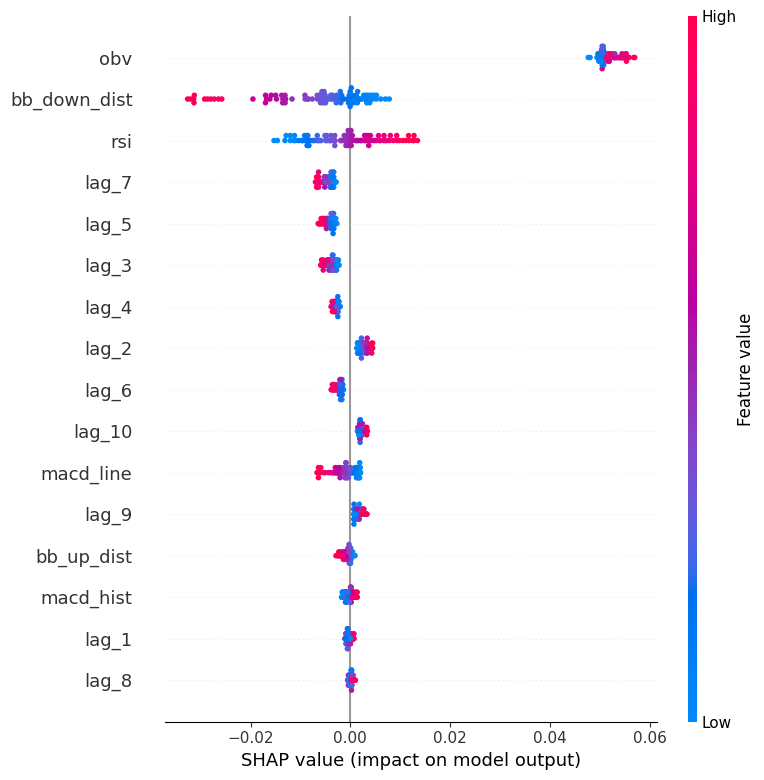

In [20]:
# ⚠️ Garante que os dados estejam em float32, exigido pelo TensorFlow
X_sample = X_test[:100].astype(np.float32)        # Amostras que vamos explicar
X_background = X_train[:100].astype(np.float32)   # Referência para o SHAP comparar

# 🧠 Criação do explicador baseado na rede neural treinada
explainer = shap.DeepExplainer(best_model, X_background)

# 📈 Cálculo dos valores SHAP para as amostras selecionadas
shap_values = explainer.shap_values(X_sample)

# ⚠️ Remove dimensão extra (forma vem como (100, 16, 1))
shap_values = np.squeeze(shap_values)

# 🔎 Verificação opcional do formato e tipo
print(f"✅ Tipo: {type(shap_values)}")
print(f"✅ Shape: {shap_values.shape}")

# 📊 Gráfico de resumo: mostra impacto global de cada feature
shap.summary_plot(shap_values, X_sample, feature_names=features)

### 10.2. 📎 Gráfico de Dependência – Impacto de uma Feature Específica

Este gráfico mostra como uma variável específica impacta o modelo em cada previsão. 
Útil para entender interações e efeitos não-lineares entre variáveis.

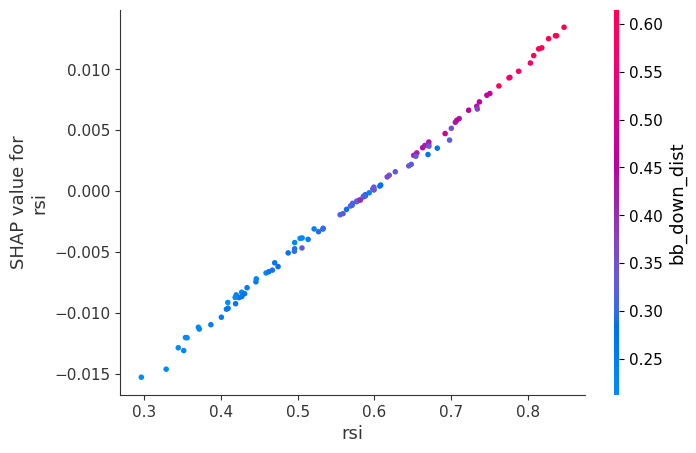

In [21]:
# Exemplo com a feature 'rsi' (ou troque por outra como 'macd_hist', 'bb_down_dist', etc.)
shap.dependence_plot("rsi", shap_values, X_sample, feature_names=features)

### 10.3. 🔍 Explicação Local – Force Plot de uma Previsão Específica

Permite entender, para uma previsão específica, o que puxou a decisão da IA para cima ou para baixo. 
É como uma "raio-x" da mente da IA.

In [22]:
# Seleciona o índice da amostra que você quer investigar
i = 5

# Necessário para visualização interativa no Jupyter Notebook
shap.initjs()

# Gera a explicação da decisão do modelo para a amostra i
shap.force_plot(
    explainer.expected_value[0],  # Valor esperado da classe
    shap_values[i],               # Contribuição de cada feature
    X_sample[i],                  # Valores reais das features
    feature_names=features
)

TypeError: Object of type EagerTensor is not JSON serializable

## 11. Carregamento do Melhor Modelo

### ♻️ Carregamento Automático do Melhor Modelo

Este bloco automatiza a busca, comparação e carregamento do modelo com melhor score salvo previamente.
Muito útil após o tuning, pois permite reutilizar o modelo sem retrainar tudo.

In [23]:
# Caminho onde os modelos estão salvos
pasta_modelos = 'ia_tuning/modelos/'

# Regex para extrair o score do nome do arquivo
padrao_score = re.compile(r'modelo_(\d+\.\d+)_\d{4}-\d{2}-\d{2}_\d{2}-\d{2}\.h5')

# Inicialização
melhor_score = -1
melhor_modelo_path = None

# Busca os arquivos e identifica o modelo com maior score
for nome_arquivo in os.listdir(pasta_modelos):
    match = padrao_score.search(nome_arquivo)
    if match:
        score = float(match.group(1))
        if score > melhor_score:
            melhor_score = score
            melhor_modelo_path = os.path.join(pasta_modelos, nome_arquivo)

# Carrega o melhor modelo encontrado
if melhor_modelo_path:
    print(f"🔍 Carregando modelo com melhor score: {melhor_score:.4f}")
    melhor_modelo = load_model(melhor_modelo_path)
else:
    print("⚠️ Nenhum modelo válido encontrado.")

🔍 Carregando modelo com melhor score: 0.5958


### ✅ Avaliação Rápida do Modelo Carregado

Após carregar automaticamente o modelo com melhor score, podemos avaliá-lo diretamente no conjunto de teste (`X_test` e `y_test`) para garantir sua acurácia real.

In [24]:
# Avalia o modelo carregado no conjunto de teste
loss, acc = melhor_modelo.evaluate(X_test, y_test, verbose=0)
print(f"✅ Acurácia do modelo carregado: {acc:.2%}")

✅ Acurácia do modelo carregado: 58.69%


## 12. Comparação dos Top 3 Modelos

### 📊 Comparativo dos Top 3 Modelos Salvos

Essa análise varre todos os arquivos `.h5` da pasta `ia_tuning/modelos/`, extrai os 3 com maior score (`val_accuracy` no nome do arquivo), e os avalia de forma real no conjunto de teste (`X_test`).

Essa verificação é útil para auditar se o modelo salvo com melhor score realmente é o que melhor generaliza.

In [25]:
# 10.2 🔍 Comparativo dos 3 Melhores Modelos Salvos

# 🗂️ Caminho onde os modelos estão salvos
pasta_modelos = 'ia_tuning/modelos/'

# 🔍 Regex para identificar arquivos no formato: modelo_0.5812_2025-04-21_01-34.h5
padrao = re.compile(r'modelo_(\d+\.\d+)_([\d\-]+_[\d\-]+)\.h5')

# 📋 Lista com (score, timestamp, caminho)
modelos_info = []

# 🔄 Loop pelos arquivos da pasta e coleta dos dados
for arquivo in os.listdir(pasta_modelos):
    match = padrao.match(arquivo)
    if match:
        score = float(match.group(1))
        timestamp = match.group(2)
        path = os.path.join(pasta_modelos, arquivo)
        modelos_info.append((score, timestamp, path))

# 🥇 Ordena do maior para o menor score
modelos_info.sort(reverse=True)

# 🎯 Seleciona os 3 melhores
top_3 = modelos_info[:3]

# 📊 Avaliação real no X_test
print("📊 Avaliando os 3 melhores modelos:\n")
for idx, (score, timestamp, path) in enumerate(top_3, start=1):
    modelo = load_model(path)
    loss, acc = modelo.evaluate(X_test, y_test, verbose=0)
    print(f"#️⃣ {idx} - 🧠 Modelo: {os.path.basename(path)}")
    print(f"   🏆 Score (val_accuracy): {score:.4f}")
    print(f"   ✅ Acurácia real no X_test: {acc:.4f}\n")

📊 Avaliando os 3 melhores modelos:

#️⃣ 1 - 🧠 Modelo: modelo_0.5958_2025-04-21_01-34.h5
   🏆 Score (val_accuracy): 0.5958
   ✅ Acurácia real no X_test: 0.5869



#️⃣ 2 - 🧠 Modelo: modelo_0.5913_2025-04-21_04-22.h5
   🏆 Score (val_accuracy): 0.5913
   ✅ Acurácia real no X_test: 0.5913

#️⃣ 3 - 🧠 Modelo: modelo_0.5813_2025-04-21_01-16.h5
   🏆 Score (val_accuracy): 0.5813
   ✅ Acurácia real no X_test: 0.5590

